**Question answering (QA)** is a field of computer science and artificial intelligence that involves building systems that automatically answer questions in a natural language. 

**QA** systems can use different sources of information, such as knowledge bases, documents, or passages of text. **QA** is also a task of natural language processing (NLP) that measures how well a machine comprehends a text and finds the most relevant answer for a question. **QA** can be applied to various domains and scenarios, such as community, knowledge-base, or conversational question answering.

Install the Transformers, Datasets, and Evaluate libraries to run this notebook.

In [ ]:
%%capture
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate
# To run the training on TPU, you will need to uncomment the following line:
# !pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!apt install git-lfs

# Load dataset

**Stanford Question Answering Dataset (SQuAD)** is a reading comprehension dataset, consisting of questions posed by crowdworkers on a set of Wikipedia articles, where the answer to every question is a segment of text, or span, from the corresponding reading passage, or the question might be unanswerable.

Link: https://huggingface.co/datasets/squad

In [ ]:
from datasets import load_dataset

data = load_dataset("squad")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

Dataset squad downloaded and prepared to /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
data

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

In [ ]:
# inspect dataset
df = data['train'].to_pandas()
df

,id,title,context,question,answers
0,5733be284776f41900661182,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,"{'text': ['Saint Bernadette Soubirous'], 'answ..."
1,5733be284776f4190066117f,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,"{'text': ['a copper statue of Christ'], 'answe..."
2,5733be284776f41900661180,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,"{'text': ['the Main Building'], 'answer_start'..."
3,5733be284776f41900661181,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is the Grotto at Notre Dame?,{'text': ['a Marian place of prayer and reflec...
4,5733be284776f4190066117e,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What sits on top of the Main Building at Notre...,{'text': ['a golden statue of the Virgin Mary'...
...,...,...,...,...,...
87594,5735d259012e2f140011a09d,Kathmandu,"Kathmandu Metropolitan City (KMC), in order to...",In what US state did Kathmandu first establish...,"{'text': ['Oregon'], 'answer_start': [229]}"
87595,5735d259012e2f140011a09e,Kathmandu,"Kathmandu Metropolitan City (KMC), in order to...",What was Yangon previously known as?,"{'text': ['Rangoon'], 'answer_start': [414]}"
87596,5735d259012e2f140011a09f,Kathmandu,"Kathmandu Metropolitan City (KMC), in order to...",With what Belorussian city does Kathmandu have...,"{'text': ['Minsk'], 'answer_start': [476]}"
87597,5735d259012e2f140011a0a0,Kathmandu,"Kathmandu Metropolitan City (KMC), in order to...",In what year did Kathmandu create its initial ...,"{'text': ['1975'], 'answer_start': [199]}"


In [ ]:
# During training, there is only one possible answer
df['answers'].apply(lambda x: len(x['text']) != 1).sum()

0

In [ ]:
print("Context:\n", df["context"][0])
print("Question:\n", df["question"][0])
print("Answer:\n", df["answers"][0])

Context:
 Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.
Question:
 To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
Answer:
 {'text': array(['Saint Bernadette Soubirous'], dtype=object), 'answer_start': array([515], dtype=int32)}


In [ ]:
# For evaluation, however, there are several possible answers for each sample
print(data["validation"][0]["answers"])  # same 
print(data["validation"][2]["answers"])  # different

{'text': ['Denver Broncos', 'Denver Broncos', 'Denver Broncos'], 'answer_start': [177, 177, 177]}
{'text': ['Santa Clara, California', "Levi's Stadium", "Levi's Stadium in the San Francisco Bay Area at Santa Clara, California."], 'answer_start': [403, 355, 355]}


Median 693.0
Mean 754.3642164864896


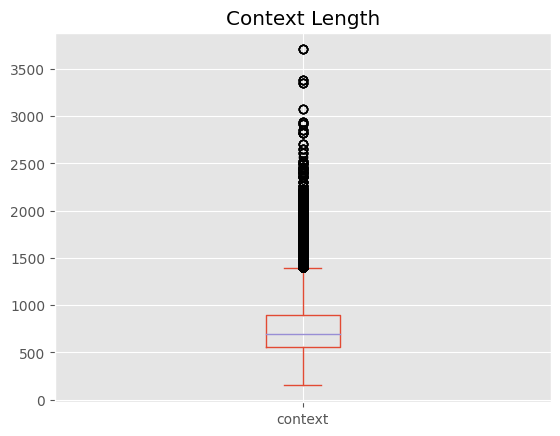

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# inspect Context
print('Median', df['context'].apply(len).median())
print('Mean', df['context'].apply(len).mean())
df['context'].apply(len).plot(kind='box', title='Context Length');

Maen 20.147273370700578
Median 14.0


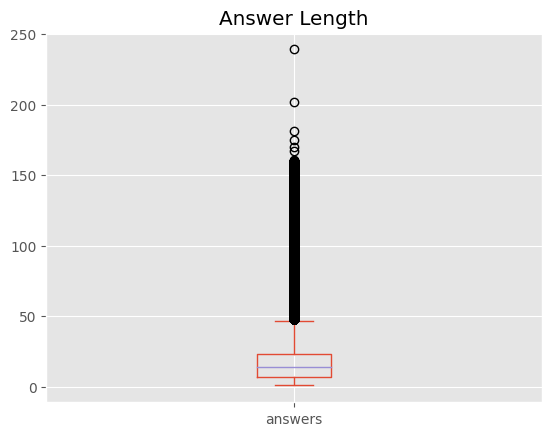

In [ ]:
# inspect Answer
print('Maen', df['answers'].apply(lambda x: x['text'][0]).apply(len).mean())
print('Median', df['answers'].apply(lambda x: x['text'][0]).apply(len).median())
df['answers'].apply(lambda x: x['text'][0]).apply(len).plot(kind='box', title='Answer Length');

# Tokenization

In [ ]:
%env TOKENIZERS_PARALLELISM=False

env: TOKENIZERS_PARALLELISM=False


In [ ]:
from transformers import AutoTokenizer

model_checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
tokenizer.is_fast

True

In [ ]:
tokenizer.special_tokens_map

{'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]'}

Our input structure: `[CLS]` question `[SEP]` context `[SEP]`

In [ ]:
context = data["train"][0]["context"]
question = data["train"][0]["question"]

inputs = tokenizer(question, context)
tokenizer.decode(inputs["input_ids"])

'[CLS] To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France? [SEP] Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend " Venite Ad Me Omnes ". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive ( and in a direct line that connects through 3 statues and the Gold Dome ), is a simple, modern stone statue of Mary. [SEP]'

The maximum length used in the question-answering pipeline is 384. So, we’ll need to split the context into smaller chunks, specifying the maximum length. To make sure we don’t split the context at exactly the wrong place to make it possible to find the answer, it also includes some overlap between the chunks.


We can have the tokenizer do this for us by adding `return_overflowing_tokens=True`, and we can specify the overlap we want with the `stride` argument. Here is an example, using a smaller sentence:

In [ ]:
inputs = tokenizer(
    data["train"][:2]["question"],   
    data["train"][:2]["context"],
    max_length=100,
    truncation="only_second",
    stride=50,  # overlaping chars
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
)

for ids in inputs["input_ids"]:
    print(tokenizer.decode(ids), '\n')

[CLS] To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France? [SEP] Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend " Venite Ad Me Omnes ". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basi [SEP] 

[CLS] To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France? [SEP] the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend " Venite Ad Me Omnes ". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin [SEP] 

[CLS] To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France? [SEP] Next to the Main Building is t

using `overflow_to_sample_mapping` we can see that the first sentence is split into 4 chunks as before, and the next 4 chunks come from the second sentence.

In [ ]:
print(f"The 4 examples gave {len(inputs['input_ids'])} features.")
print(f"Here is where each comes from: {inputs['overflow_to_sample_mapping']}.")

The 4 examples gave 8 features.
Here is where each comes from: [0, 0, 0, 0, 1, 1, 1, 1].


This information will be useful to map each feature we get to its corresponding label. Those labels are:

- `(0, 0)` if the answer is not in the corresponding span of the context.
- `(start_position, end_position)` if the answer is in the corresponding span of the context, with `start_position` being the index of the token (in the input IDs) at the start of the answer and `end_position` being the index of the token (in the input IDs) where the answer ends.

# Pre-Processing


## Preprocess Training Data

In [ ]:
max_length = 384
stride = 128


def preprocess_training_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label is (0, 0)
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [ ]:
train_dataset = data["train"].map(
    preprocess_training_examples,
    batched=True,
    remove_columns=data["train"].column_names,
)
len(data["train"]), len(train_dataset)

Map:   0%|          | 0/87599 [00:00<?, ? examples/s]

(87599, 88729)

As we can see, the preprocessing added roughly 1,000 features because of the offsets.

## Preprocess Validation Data

Preprocessing the validation data will be slightly easier as we don’t need to generate labels.

We will just need to store both the offset mappings and some way to match each created feature to the original example it comes from -Since there is an `ID` column in the original dataset, we’ll use that `ID`- to interpret the predictions of the model into spans of the original context..


The only thing we’ll add here is a tiny bit of cleanup of the offset mappings. They will contain offsets for the question and the context, but once we’re in the post-processing stage we won’t have any way to know which part of the input IDs corresponded to the context and which part was the question (the `sequence_ids()` method we used is available for the output of the tokenizer only). So, we’ll set the offsets corresponding to the question to `None`.

In [ ]:
def preprocess_validation_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs

In [ ]:
validation_dataset = data["validation"].map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=data["validation"].column_names,
)
len(data["validation"]), len(validation_dataset)

Map:   0%|          | 0/10570 [00:00<?, ? examples/s]

(10570, 10822)

# FineTune

In [ ]:
import torch
from transformers import AutoModelForQuestionAnswering

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint).to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForQuestionAnswering: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-cased and a

In [ ]:
from transformers import TrainingArguments

args = TrainingArguments(
    "bert-finetuned-squad",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    optim="adamw_torch",
    logging_steps=3000,
    fp16=True,
    push_to_hub=False,
    report_to='none',
    disable_tqdm=False,
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=tokenizer,
)
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,1.111600,No log
2,0.714800,No log
3,0.435900,No log


TrainOutput(global_step=33276, training_loss=0.8018453921072614, metrics={'train_runtime': 8229.2603, 'train_samples_per_second': 32.346, 'train_steps_per_second': 4.044, 'total_flos': 5.216534983896422e+16, 'train_loss': 0.8018453921072614, 'epoch': 3.0})

# Evaluation

In [ ]:
import evaluate

metric = evaluate.load("squad")

In [ ]:
from tqdm.auto import tqdm
import numpy as np
import collections

n_best = 20 # top 20 logits propabilities
max_answer_length = 30

def compute_metrics(start_logits, end_logits, features, examples):
    example_to_features = collections.defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx)

    predicted_answers = []
    for example in tqdm(examples):
        example_id = example["id"]
        context = example["context"]
        answers = []

        # Loop through all features associated with that example
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]

            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Skip answers that are not fully in the context
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    # Skip answers with a length that is either < 0 or > max_answer_length
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue

                    answer = {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                    answers.append(answer)

        # Select the answer with the best score
        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append(
                {"id": example_id, "prediction_text": best_answer["text"]}
            )
        else:
            predicted_answers.append({"id": example_id, "prediction_text": ""})

    theoretical_answers = [{"id": ex["id"], "answers": ex["answers"]} for ex in examples]
    return metric.compute(predictions=predicted_answers, references=theoretical_answers)

In [ ]:
predictions, _, _ = trainer.predict(validation_dataset)
start_logits, end_logits = predictions
compute_metrics(start_logits, end_logits, validation_dataset, data["validation"])

  0%|          | 0/10570 [00:00<?, ?it/s]

{'exact_match': 80.54872280037843, 'f1': 88.31958404630606}

Great! As a comparison, the baseline scores reported in the BERT article for this model are 80.8 and 88.5, so we’re right where we should be.

# Inference

In [ ]:
context = """
Transformers proposes a new simple network architecture based solely on attention mechanisms, 
dispensing with recurrence and convolutions entirely. 
The Transformer has been shown to be superior in quality while being more parallelizable and requiring significantly less time to train.
"""
question = "What is the Transformer architecture based on?"

In [ ]:
inputs = tokenizer(question, context, return_tensors='pt').to(device)
with torch.no_grad():
  outputs = model(**inputs)

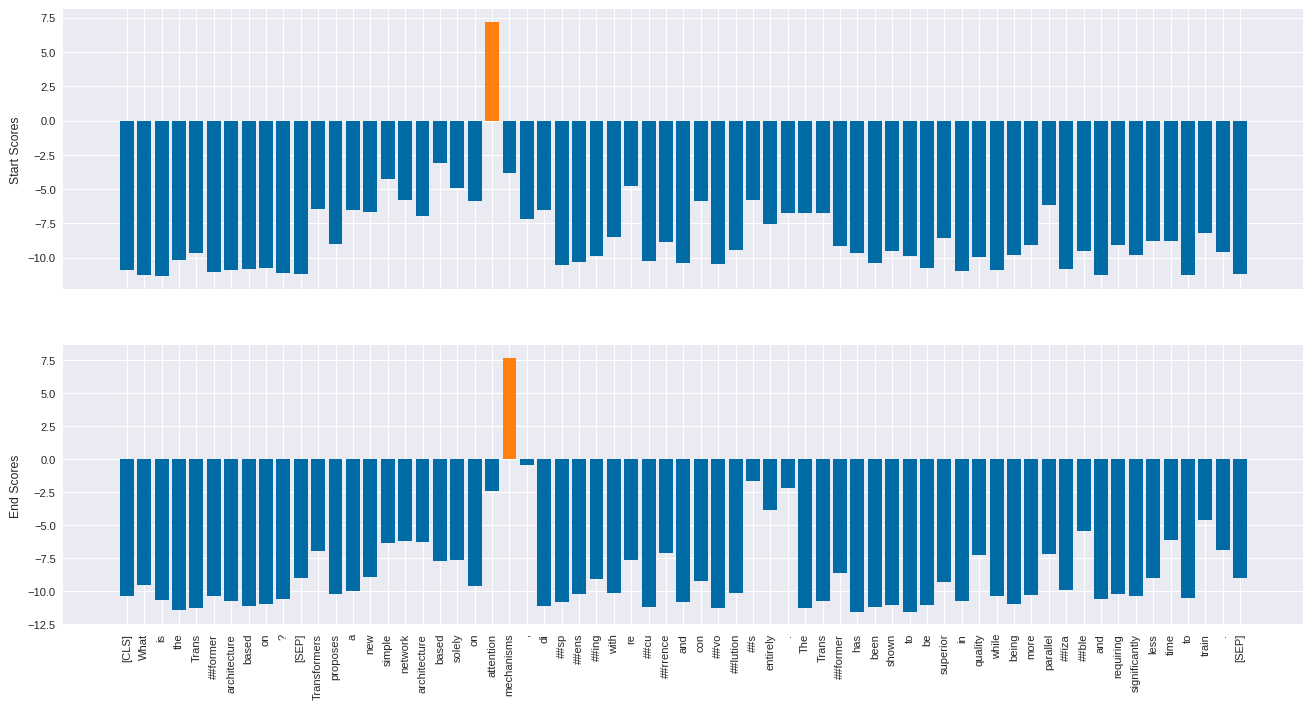

In [ ]:
# plot answer probabilities
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')

s_scores = outputs.start_logits.cpu().detach().numpy().flatten()
e_scores = outputs.end_logits.cpu().detach().numpy().flatten()
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
token_ids = range(len(tokens))

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(16,8))
colors = ["C0" if s != np.max(s_scores) else "C1" for s in s_scores]
ax1.bar(x=token_ids, height=s_scores, color=colors)
ax1.set_ylabel("Start Scores")
colors = ["C0" if s != np.max(e_scores) else "C1" for s in e_scores]
ax2.bar(x=token_ids, height=e_scores, color=colors)
ax2.set_ylabel("End Scores")
plt.xticks(token_ids, tokens, rotation="vertical")
plt.show()

In [ ]:
# get the answer (text)
answer_start_index = outputs.start_logits.argmax()
answer_end_index = outputs.end_logits.argmax()

predict_answer_tokens = inputs.input_ids[0, answer_start_index: answer_end_index+1]
tokenizer.decode(predict_answer_tokens)

'attention mechanisms'

# Resources:

- [Natural Language Processing with Transformers](https://transformersbook.com/)
- [HuggingFace Course](https://huggingface.co/course/chapter6/3b?fw=pt#using-a-model-for-question-answering)